In [3]:
# Imports and settings


import numpy as np
import matplotlib.pyplot as plt
print(plt.style.available)
# Use an available style
plt.style.use('seaborn-v0_8-white')  # or 'seaborn-v0_8-whitegrid'
plt.rcParams.update({'pdf.fonttype': 'truetype'})



['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


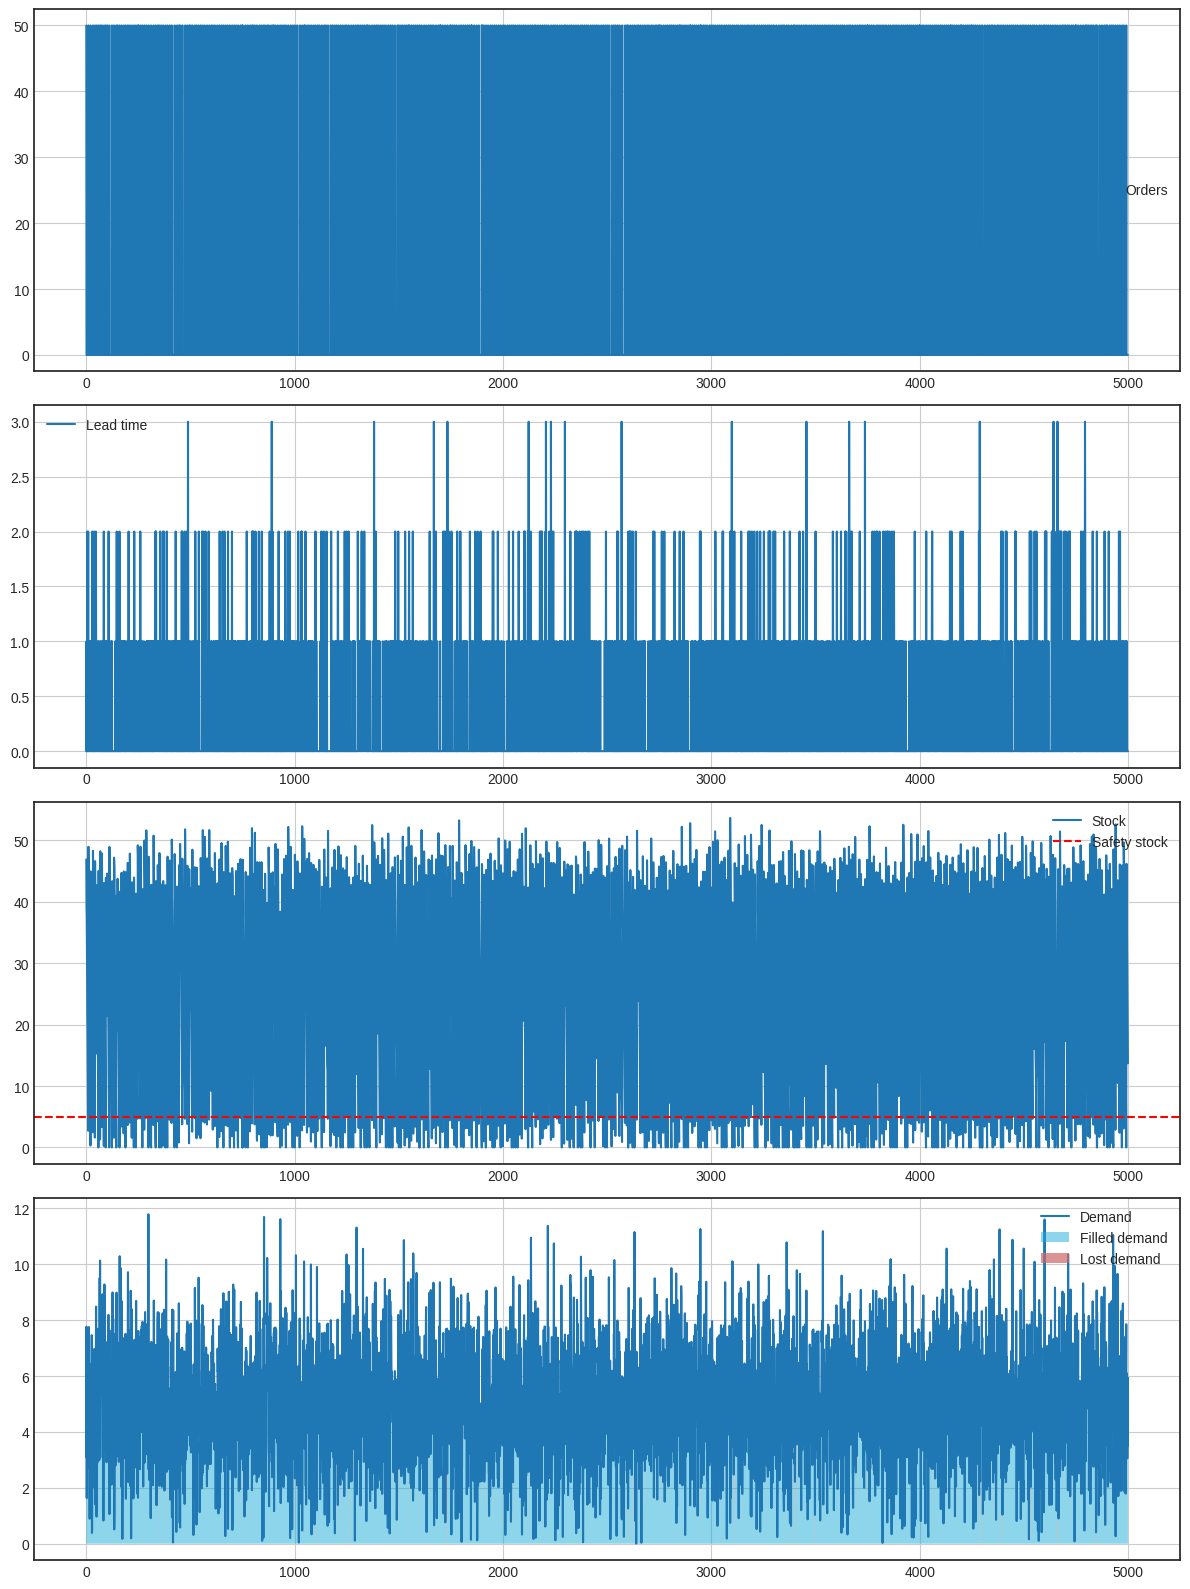

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#
# Random generators
#
class Generator:
    def next(self):
        pass

class ConstantGenerator(Generator):
    def __init__(self, mu):
        self.mu = mu

    def next(self):
        return self.mu

class NormalGenerator(Generator):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def next(self):
        return np.random.normal(self.mu, self.sigma, 1)[0]

class FoldedNormalGenerator(Generator):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def next(self):
        return abs(np.random.normal(self.mu, self.sigma, 1)[0])

class HalfNormalGenerator(Generator):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def next(self):
        return abs(np.random.normal(self.mu, self.sigma, 1)[0])

#
# Inventory policies
#
class InventoryPolicy:
    def get_order_quantity(self, supply_chain):
        pass

class sQInventoryPolicy(InventoryPolicy):
    def __init__(self, s, Q):
        self.s = s
        self.Q = Q

    def __str__(self):
        return f'(s={self.s}, Q={self.Q})'

    def get_order_quantity(self, supply_chain):
        net_inventory = supply_chain.get_stock() + supply_chain.get_intransit()
        if net_inventory <= self.s:
            return self.Q
        else:
            return 0

#
# Supply chain simulator
#
class SupplyChain:
    def __init__(self, config):
        self.orders = []
        self.stock = []
        self.demand = []
        self.lead_times = []
        self.t = 0

        self.fixed_tx_cost = config['fixed_transaction_cost']
        self.variable_tx_cost = config['variable_transaction_cost']
        self.holding_cost = config['holding_cost']
        self.demand_generator = config['demand_generator']
        self.lead_time_generator = config['lead_time_generator']
        self.policy = config['policy']

        # auxiliary variables for efficiency calculations
        self._filled_demand = []
        self._fixed_tx_costs = []
        self._variable_tx_costs = []
        self._holding_costs = []

    def get_stock(self):
        if not self.stock:
            return 0
        else:
            return self.stock[-1]

    def get_intransit(self):
        in_transit = 0
        for i in range(self.t):
            if self.t <= i + self.lead_times[i]:
                in_transit += self.orders[i]
        return in_transit

    def process_demand(self):
        demand = self.demand_generator.next()
        self.demand.append(demand)

        filled_demand = min(demand, self.stock[self.t])
        self.stock[self.t] -= filled_demand

        self._filled_demand.append(filled_demand)

    def place_order(self):
        order = self.policy.get_order_quantity(self)
        self.orders.append(order)

        lead_time = int(self.lead_time_generator.next())
        self.lead_times.append(lead_time)

    def procees_orders(self):
        new_stock = 0
        for i in range(self.t + 1):
            if self.t == i + self.lead_times[i]:
                new_stock += self.orders[i]

        self.stock.append(self.get_stock() + new_stock)

    def update_costs(self):
        if self.orders[self.t] != 0:
            self._fixed_tx_costs.append(self.fixed_tx_cost)
            self._variable_tx_costs.append(self.orders[self.t] * self.variable_tx_cost)
        else:
            self._fixed_tx_costs.append(0)
            self._variable_tx_costs.append(0)
        self._holding_costs.append(self.stock[self.t] * self.holding_cost)

    def act(self):
        self.place_order()
        self.procees_orders()
        self.process_demand()
        self.update_costs()
        self.t += 1

def plot_all_episodes(all_data):
    fig, ax = plt.subplots(4, 1, figsize=(12, 16))

    x = np.arange(len(all_data['orders']))
    ax[0].plot(x, all_data['orders'], label='Orders')
    ax[1].plot(x, all_data['lead_times'], label='Lead time')

    ax[2].plot(x, all_data['stock'], label='Stock')
    ax[2].axhline(5, color='red', label='Safety stock', linestyle='--')

    ax[3].plot(x, all_data['demand'], label='Demand')
    ax[3].fill_between(x, np.zeros(len(x)), all_data['filled_demand'], facecolor="#1DACD6", alpha=.5, label='Filled demand')
    ax[3].fill_between(x, all_data['filled_demand'], all_data['demand'], facecolor="#CC6666", alpha=.7, label='Lost demand')

    for axi in ax:
        axi.grid(True)
        axi.legend()

    plt.tight_layout()
    plt.show()

##########################################################################

# Configuration
config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'demand_generator': HalfNormalGenerator(5, 2),
    'lead_time_generator': HalfNormalGenerator(0, 1),
    'policy': sQInventoryPolicy(5, 50)
}

# Run simulation for multiple episodes
episodes = 100
steps_per_episode = 50
all_data = {
    'orders': [],
    'lead_times': [],
    'stock': [],
    'demand': [],
    'filled_demand': [],
}

for episode in range(episodes):
    simulator = SupplyChain(config)
    for t in range(steps_per_episode):
        simulator.act()

    # Collect data for plotting
    all_data['orders'].extend(simulator.orders)
    all_data['lead_times'].extend(simulator.lead_times)
    all_data['stock'].extend(simulator.stock)
    all_data['demand'].extend(simulator.demand)
    all_data['filled_demand'].extend(simulator._filled_demand)

# Plot consolidated data for all episodes
plot_all_episodes(all_data)


NameError: name 'RSInventoryPolicy' is not defined

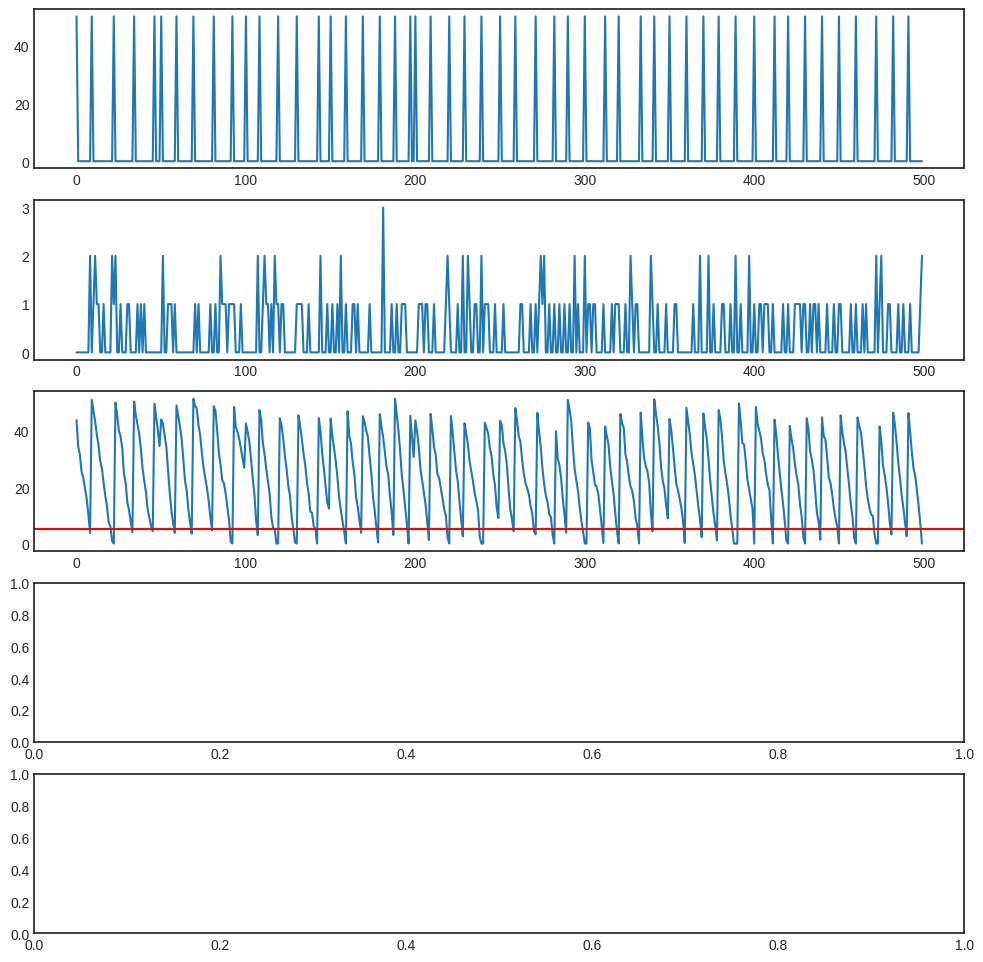

In [5]:
def plot_supply_chain_detail(supply_chain, title):
    fig, ax = plt.subplots(5, 1, figsize=(12, 12))
    x = np.arange(supply_chain.t)
    ax[0].plot(x, supply_chain.orders, label='Orders')
    ax[1].plot(x, supply_chain.lead_times, label='Lead time')

    ax[2].plot(x, supply_chain.stock, label='Stock')
    if isinstance(supply_chain.policy, sQInventoryPolicy):
        ax[2].axhline(supply_chain.policy.s, color='red', label='Safety stock')
    if isinstance(supply_chain.policy, RSInventoryPolicy):
        ax[2].axhline(supply_chain.policy.S, color='red', label='Up-to level')

    ax[3].plot(x, supply_chain.demand, label='Demand')
    ax[3].fill_between(x, np.zeros(len(x)), supply_chain._filled_demand, facecolor="#1DACD6", alpha=.5, label='Filled demand')
    ax[3].fill_between(x, supply_chain._filled_demand, supply_chain.demand, facecolor="#CC6666", alpha=.7, label='Lost demand')

    # If these lists are shorter than x, extend them with zeros to match the length
    fc = np.cumsum(supply_chain._fixed_tx_costs + [0] * (len(x) - len(supply_chain._fixed_tx_costs)))
    vc = np.cumsum(supply_chain._variable_tx_costs + [0] * (len(x) - len(supply_chain._variable_tx_costs)))
    hc = np.cumsum(supply_chain._holding_costs + [0] * (len(x) - len(supply_chain._holding_costs)))
    ax[4].fill_between(x, np.zeros(len(x)), fc, alpha=0.5, label='Fixed costs')
    ax[4].fill_between(x, fc, fc + vc, alpha=0.5, label='Variable costs')
    ax[4].fill_between(x, fc + vc, fc + vc + hc, alpha=0.5, label='Holding costs')

    for axi in ax:
        axi.grid(True)
        axi.legend()

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

##########################################################################

config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'demand_generator': HalfNormalGenerator(5, 2),
    'lead_time_generator': HalfNormalGenerator(0, 1),
    'policy': sQInventoryPolicy(5, 50)
}

# Simulation parameters
episodes = 100
steps_per_episode = 50

data_per_graph = 500  # 10 episodes per graph (10 x 50 = 500)
num_graphs = episodes // 10

data = {
    'orders': [],
    'lead_times': [],
    'stock': [],
    'demand': [],
    'filled_demand': []
}

for episode in range(episodes):
    simulator = SupplyChain(config)
    for t in range(steps_per_episode):
        simulator.act()

    # Collect data for plotting
    data['orders'].extend(simulator.orders)
    data['lead_times'].extend(simulator.lead_times)
    data['stock'].extend(simulator.stock)
    data['demand'].extend(simulator.demand)
    data['filled_demand'].extend(simulator._filled_demand)

# Plot graphs in chunks
for graph_idx in range(num_graphs):
    start = graph_idx * data_per_graph
    end = start + data_per_graph

    chunk_data = {
        'orders': data['orders'][start:end],
        'lead_times': data['lead_times'][start:end],
        'stock': data['stock'][start:end],
        'demand': data['demand'][start:end],
        'filled_demand': data['filled_demand'][start:end]
    }

    simulator = SupplyChain(config)  # Dummy simulator for labels
    simulator.orders = chunk_data['orders']
    simulator.lead_times = chunk_data['lead_times']
    simulator.stock = chunk_data['stock']
    simulator.demand = chunk_data['demand']
    simulator._filled_demand = chunk_data['filled_demand']
    simulator.t = data_per_graph

    plot_supply_chain_detail(simulator, title=f"Supply Chain Simulation - Graph {graph_idx + 1}")


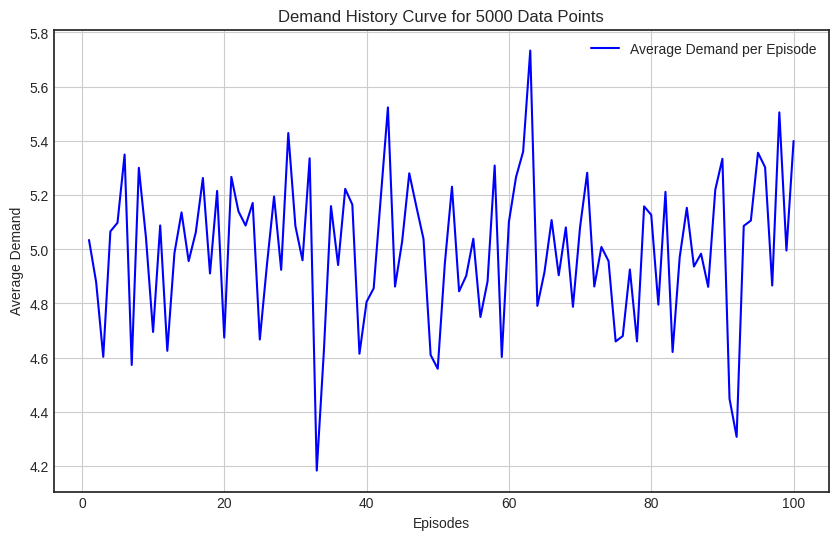

In [6]:
# Simulation Parameters
episodes = 100
steps_per_episode = 50

demand_history = []  # Store demand for all episodes

# Run simulation for demand data points
for episode in range(episodes):
    episode_demand = []
    demand_generator = config['demand_generator']
    for t in range(steps_per_episode):
        demand = demand_generator.next()
        episode_demand.append(demand)
    demand_history.append(np.mean(episode_demand))

# Create x-axis labels for episodes
x = np.arange(1, episodes + 1)

# Plot the demand history curve
plt.figure(figsize=(10, 6))
plt.plot(x, demand_history, label="Average Demand per Episode", color="blue")
plt.title("Demand History Curve for 5000 Data Points")
plt.xlabel("Episodes")
plt.ylabel("Average Demand")
plt.grid(True)
plt.legend()
plt.show()


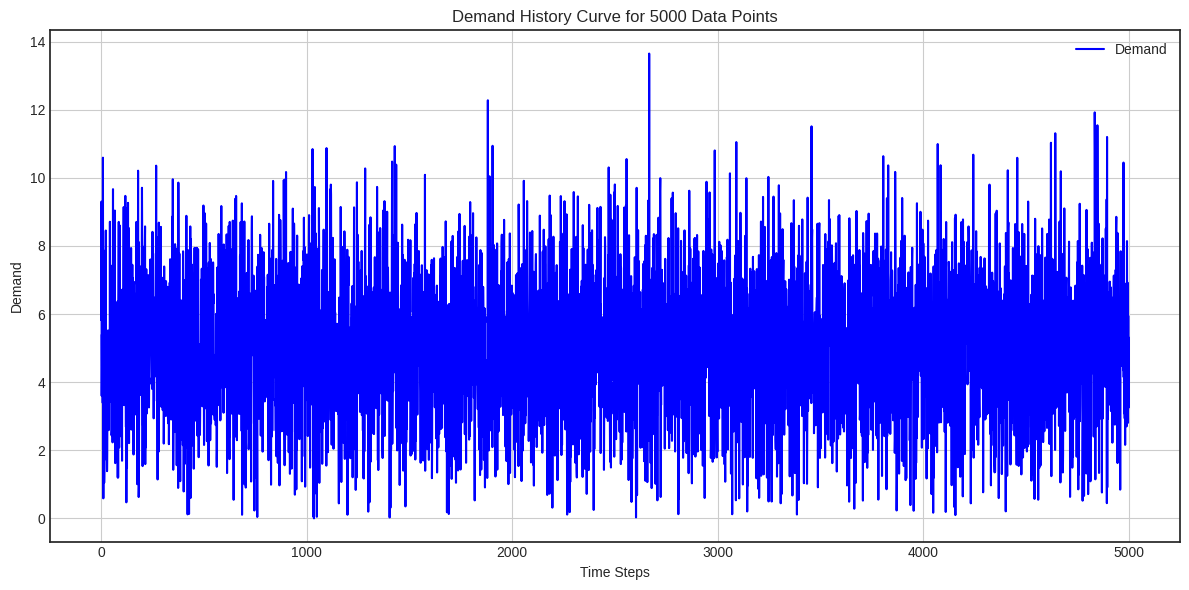

In [7]:

# Demand History Plot for 5000 Data Points


# Parameters
episodes = 100
steps_per_episode = 50

# Collect demand history
demand_history = []

for episode in range(episodes):
    simulator = SupplyChain(config)
    for t in range(steps_per_episode):
        simulator.act()
    demand_history.extend(simulator.demand)

# Plot demand history
plt.figure(figsize=(12, 6))
x = np.arange(len(demand_history))  # Time steps
plt.plot(x, demand_history, label="Demand", color="blue")
plt.title("Demand History Curve for 5000 Data Points")
plt.xlabel("Time Steps")
plt.ylabel("Demand")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
#
# Helper functions for performance metrics calculation based on the simulation traces
#
def get_holding_costs(supply_chain):
    return np.sum(supply_chain._holding_costs)

def get_fixed_transaction_costs(supply_chain):
    return np.sum(supply_chain._fixed_tx_costs)

def get_fill_rate(supply_chain):
    return 1 - np.sum(np.array(supply_chain.demand) - np.array(supply_chain._filled_demand)) / np.sum(supply_chain.demand)

def get_cycle_service_level(supply_chain):
    n_cycles, n_stock_outs = 0, 0
    is_stock_out = False
    lost_demand = np.array(supply_chain.demand) - np.array(supply_chain._filled_demand)
    for t in range(supply_chain.t):
        if supply_chain.orders[t] != 0 or t == supply_chain.t - 1:
            n_cycles += 1
            if is_stock_out:
                n_stock_outs += 1
            is_stock_out = False

        if lost_demand[t] != 0:
            is_stock_out = True

    return n_cycles, n_stock_outs, 1 - n_stock_outs/n_cycles

Cost-Optimal Order Quantity and s  for (s,Q) policy





In [13]:
import numpy as np

# Define ranges for Q and s
Q_range = np.arange(10, 1000, 50)  # Example range for Q
s_range = np.arange(1, 50, 5)      # Example range for s

# To store results
results = []

# Grid search
for Q in Q_range:
    for s in s_range:
        config['policy'] = sQInventoryPolicy(s, Q)
        total_cost = 0

        # Simulate episodes
        for episode in range(100):  # Assuming 100 episodes
            simulator = SupplyChain(config)
            for t in range(50):    # Assuming 50 steps per episode
                simulator.act()

            # Calculate costs for this episode
            total_cost += (
                sum(simulator._fixed_tx_costs) +
                sum(simulator._variable_tx_costs) +
                sum(simulator._holding_costs)
            )

        # Average cost over episodes
        avg_cost = total_cost / 100
        results.append((Q, s, avg_cost))

# Find optimal Q and s
optimal = min(results, key=lambda x: x[2])
print(f"Optimal Q: {optimal[0]}, Optimal s: {optimal[1]}, Minimum Average Cost: {optimal[2]}")


Optimal Q: 10, Optimal s: 1, Minimum Average Cost: 383.31444388315475


without considering penalty **costs**

Optimal Q: 60, Optimal s: 1, Minimum Average Total Cost: 183.2659906378829
Avg Holding Cost: 137.2659906378829, Avg Fixed Cost: 46.0
Avg Fill Rate: 0.9752070210848247, Avg Service Level: 0.4716666666666666

Metrics for Optimal Configuration:
Optimal Q: 60, Optimal s: 1
Avg Holding Cost: 137.02419002271137, Avg Fixed Cost: 45.7
Avg Total Cost: 182.72419002271138, Avg Fill Rate: 0.9751684979608162, Avg Service Level: 0.5023333333333333


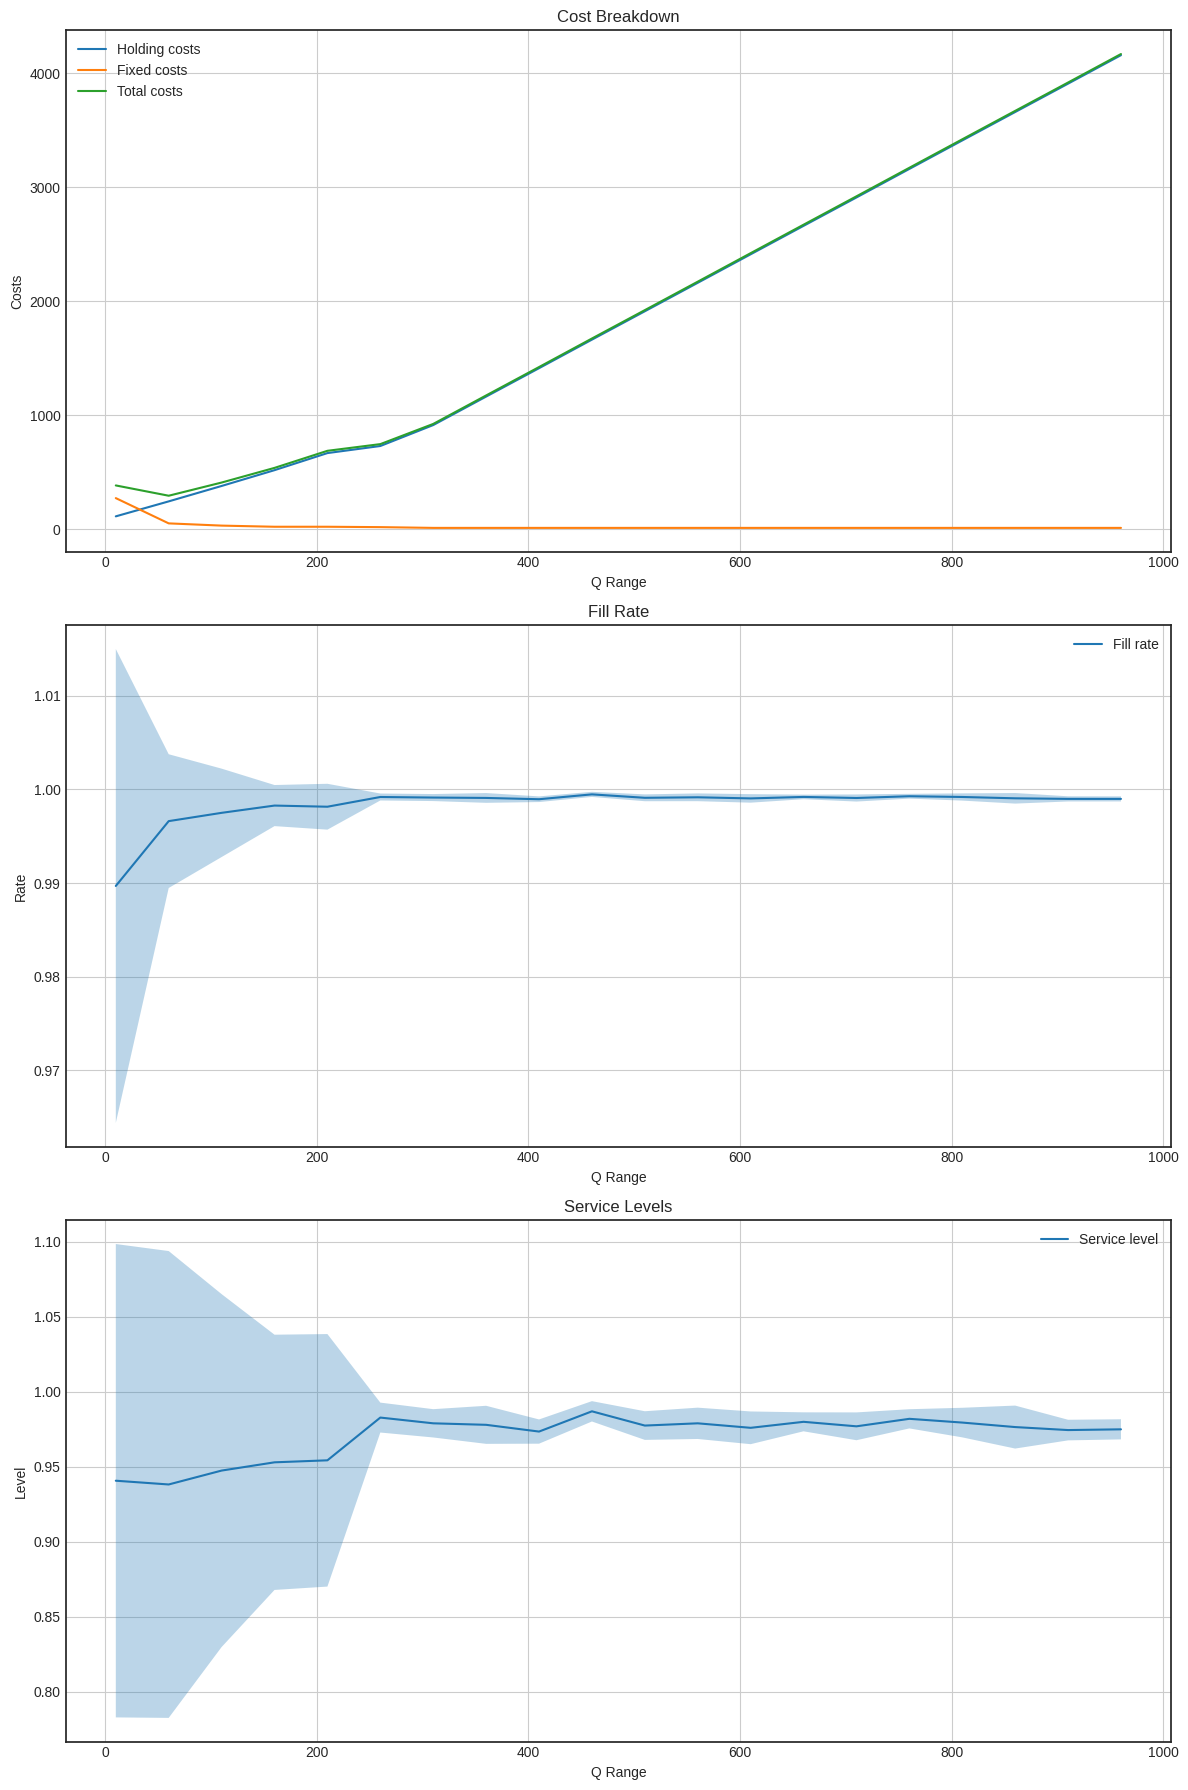

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define ranges for Q and s
Q_range = np.arange(10, 1000, 50)  # Example range for Q
s_range = np.arange(1, 50, 5)      # Example range for s

# Function to evaluate metrics for each simulation
def evaluate_metrics(simulator):
    holding_cost = np.sum(simulator._holding_costs)
    fixed_cost = np.sum(simulator._fixed_tx_costs)
    total_cost = holding_cost + fixed_cost
    fill_rate = get_fill_rate(simulator)
    cycle_service_level = get_cycle_service_level(simulator)[-1]
    return holding_cost, fixed_cost, total_cost, fill_rate, cycle_service_level

# Function to perform grid search for Q and s
def evaluate_scenarios(n_simulations, n_sim_steps, Q_range, s_range, config):
    trace_dims = (len(Q_range) * len(s_range), n_simulations)

    # Initialize arrays for metrics
    holding_costs = np.zeros(trace_dims)
    fixed_costs = np.zeros(trace_dims)
    total_costs = np.zeros(trace_dims)
    fill_rates = np.zeros(trace_dims)
    service_levels = np.zeros(trace_dims)

    results = []

    for i, Q in enumerate(Q_range):
        for j, s in enumerate(s_range):
            config['policy'] = sQInventoryPolicy(s, Q)
            index = i * len(s_range) + j

            for k in range(n_simulations):
                simulator = SupplyChain(config)
                for t in range(n_sim_steps):
                    simulator.act()

                # Calculate metrics for this simulation
                holding_cost, fixed_cost, total_cost, fill_rate, service_level = evaluate_metrics(simulator)
                holding_costs[index][k] = holding_cost
                fixed_costs[index][k] = fixed_cost
                total_costs[index][k] = total_cost
                fill_rates[index][k] = fill_rate
                service_levels[index][k] = service_level

            # Aggregate metrics
            avg_holding_cost = np.mean(holding_costs[index])
            avg_fixed_cost = np.mean(fixed_costs[index])
            avg_total_cost = np.mean(total_costs[index])
            avg_fill_rate = np.mean(fill_rates[index])
            avg_service_level = np.mean(service_levels[index])

            results.append({
                'Q': Q,
                's': s,
                'avg_holding_cost': avg_holding_cost,
                'avg_fixed_cost': avg_fixed_cost,
                'avg_total_cost': avg_total_cost,
                'avg_fill_rate': avg_fill_rate,
                'avg_service_level': avg_service_level
            })

    return results, holding_costs, fixed_costs, total_costs, fill_rates, service_levels

# Visualization of results
def plot_results(results, Q_range, s_range):
    total_costs = np.array([res['avg_total_cost'] for res in results]).reshape(len(Q_range), len(s_range))
    fill_rates = np.array([res['avg_fill_rate'] for res in results]).reshape(len(Q_range), len(s_range))
    service_levels = np.array([res['avg_service_level'] for res in results]).reshape(len(Q_range), len(s_range))

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Total cost plot
    avg_holding_costs = np.array([res['avg_holding_cost'] for res in results]).reshape(len(Q_range), len(s_range))
    avg_fixed_costs = np.array([res['avg_fixed_cost'] for res in results]).reshape(len(Q_range), len(s_range))

    x = Q_range
    axs[0].plot(x, np.mean(avg_holding_costs, axis=1), label='Holding costs')
    axs[0].plot(x, np.mean(avg_fixed_costs, axis=1), label='Fixed costs')
    axs[0].plot(x, np.mean(total_costs, axis=1), label='Total costs')
    axs[0].set_title("Cost Breakdown")
    axs[0].set_xlabel("Q Range")
    axs[0].set_ylabel("Costs")
    axs[0].legend()
    axs[0].grid(True)

    # Fill rate plot
    axs[1].plot(x, np.mean(fill_rates, axis=1), label='Fill rate')
    axs[1].fill_between(x, np.mean(fill_rates, axis=1) - np.std(fill_rates, axis=1), np.mean(fill_rates, axis=1) + np.std(fill_rates, axis=1), alpha=0.3)
    axs[1].set_title("Fill Rate")
    axs[1].set_xlabel("Q Range")
    axs[1].set_ylabel("Rate")
    axs[1].legend()
    axs[1].grid(True)

    # Service level plot
    axs[2].plot(x, np.mean(service_levels, axis=1), label='Service level')
    axs[2].fill_between(x, np.mean(service_levels, axis=1) - np.std(service_levels, axis=1), np.mean(service_levels, axis=1) + np.std(service_levels, axis=1), alpha=0.3)
    axs[2].set_title("Service Levels")
    axs[2].set_xlabel("Q Range")
    axs[2].set_ylabel("Level")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

# Simulation configuration
config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'demand_generator': FoldedNormalGenerator(5, 0.5),
    'lead_time_generator': FoldedNormalGenerator(0, 0.5),
    'policy': None
}

# Parameters
n_simulations = 100
n_sim_steps = 50

# Run simulations
evaluation_results, holding_costs, fixed_costs, total_costs, fill_rates, service_levels = evaluate_scenarios(n_simulations, n_sim_steps, Q_range, s_range, config)

# Find optimal configuration based on total cost
optimal = min(evaluation_results, key=lambda x: x['avg_total_cost'])
print(f"Optimal Q: {optimal['Q']}, Optimal s: {optimal['s']}, Minimum Average Total Cost: {optimal['avg_total_cost']}")
print(f"Avg Holding Cost: {optimal['avg_holding_cost']}, Avg Fixed Cost: {optimal['avg_fixed_cost']}")
print(f"Avg Fill Rate: {optimal['avg_fill_rate']}, Avg Service Level: {optimal['avg_service_level']}")

# Re-evaluate metrics using optimal Q and s
def evaluate_optimal_metrics(optimal_Q, optimal_s, n_simulations, n_sim_steps, config):
    config['policy'] = sQInventoryPolicy(optimal_s, optimal_Q)

    holding_costs = []
    fixed_costs = []
    total_costs = []
    fill_rates = []
    service_levels = []

    for _ in range(n_simulations):
        simulator = SupplyChain(config)
        for t in range(n_sim_steps):
            simulator.act()

        # Collect metrics
        holding_cost, fixed_cost, total_cost, fill_rate, service_level = evaluate_metrics(simulator)
        holding_costs.append(holding_cost)
        fixed_costs.append(fixed_cost)
        total_costs.append(total_cost)
        fill_rates.append(fill_rate)
        service_levels.append(service_level)

    # Compute averages
    avg_holding_cost = np.mean(holding_costs)
    avg_fixed_cost = np.mean(fixed_costs)
    avg_total_cost = np.mean(total_costs)
    avg_fill_rate = np.mean(fill_rates)
    avg_service_level = np.mean(service_levels)

    print("\nMetrics for Optimal Configuration:")
    print(f"Optimal Q: {optimal_Q}, Optimal s: {optimal_s}")
    print(f"Avg Holding Cost: {avg_holding_cost}, Avg Fixed Cost: {avg_fixed_cost}")
    print(f"Avg Total Cost: {avg_total_cost}, Avg Fill Rate: {avg_fill_rate}, Avg Service Level: {avg_service_level}")

# Evaluate metrics for the optimal Q and s
evaluate_optimal_metrics(optimal['Q'], optimal['s'], n_simulations, n_sim_steps, config)

# Plot results
plot_results(evaluation_results, Q_range, s_range)


included penalty costs


Optimal Q: 60, Optimal s: 6, Minimum Average Total Cost: 210.9767650805469
Avg Holding Cost: 157.77307339087886, Avg Fixed Cost: 49.9, Avg Stockout Cost: 3.303691689668093
Avg Fill Rate: 0.9973472208343501, Avg Service Level: 0.9543333333333334

Metrics for Optimal Configuration:
Optimal Q: 60, Optimal s: 6
Avg Holding Cost: 159.74432394703405, Avg Fixed Cost: 50.0, Avg Stockout Cost: 2.139608370456573
Avg Total Cost: 211.8839323174906, Avg Fill Rate: 0.9982958568232339, Avg Service Level: 0.9793333333333333


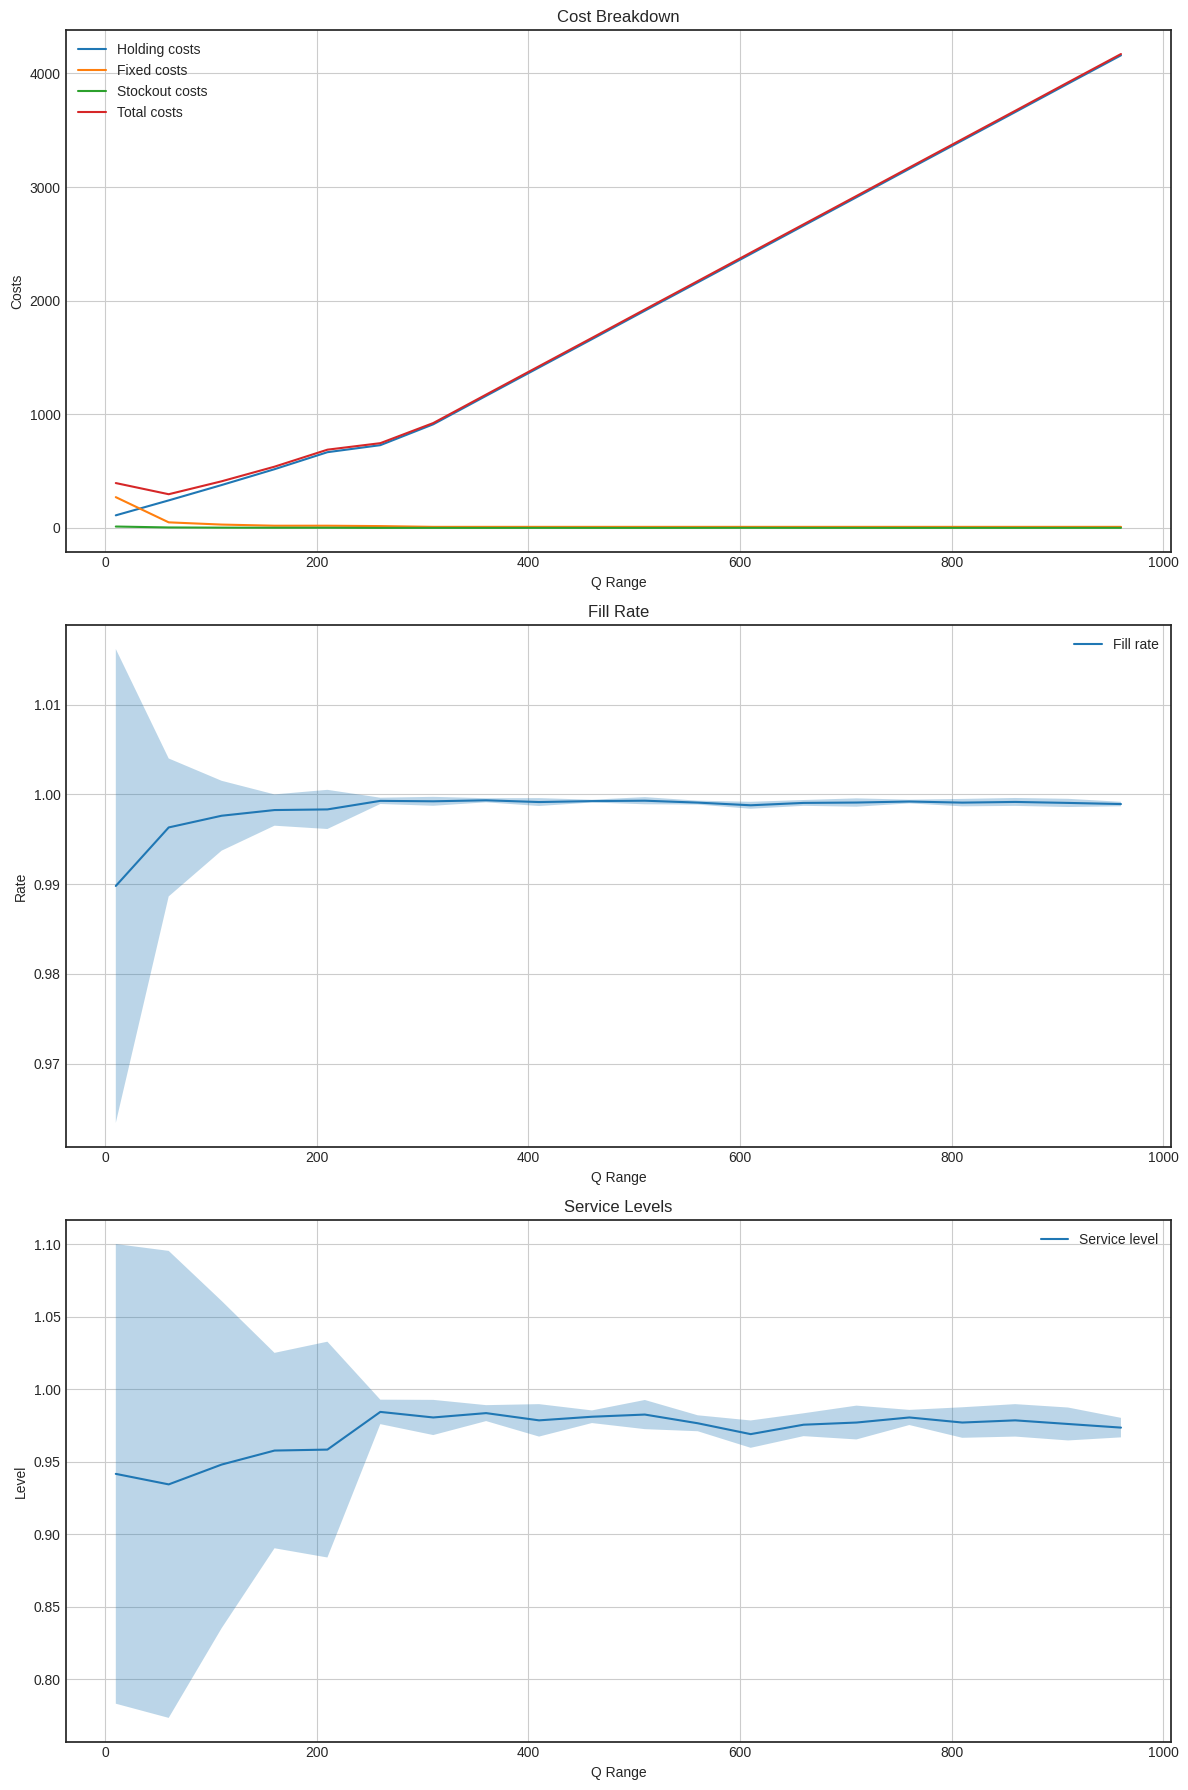

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define ranges for Q and s
Q_range = np.arange(10, 1000, 50)  # Example range for Q
s_range = np.arange(1, 50, 5)      # Example range for s

# Function to evaluate metrics for each simulation
def evaluate_metrics(simulator, penalty_rate):
    holding_cost = np.sum(simulator._holding_costs)
    fixed_cost = np.sum(simulator._fixed_tx_costs)
    stockout_cost = penalty_rate * np.sum(np.maximum(0, np.array(simulator.demand) - np.array(simulator._filled_demand)))
    total_cost = holding_cost + fixed_cost + stockout_cost
    fill_rate = get_fill_rate(simulator)
    cycle_service_level = get_cycle_service_level(simulator)[-1]
    return holding_cost, fixed_cost, stockout_cost, total_cost, fill_rate, cycle_service_level

# Function to perform grid search for Q and s
def evaluate_scenarios(n_simulations, n_sim_steps, Q_range, s_range, config, penalty_rate):
    trace_dims = (len(Q_range) * len(s_range), n_simulations)

    # Initialize arrays for metrics
    holding_costs = np.zeros(trace_dims)
    fixed_costs = np.zeros(trace_dims)
    stockout_costs = np.zeros(trace_dims)
    total_costs = np.zeros(trace_dims)
    fill_rates = np.zeros(trace_dims)
    service_levels = np.zeros(trace_dims)

    results = []

    for i, Q in enumerate(Q_range):
        for j, s in enumerate(s_range):
            config['policy'] = sQInventoryPolicy(s, Q)
            index = i * len(s_range) + j

            for k in range(n_simulations):
                simulator = SupplyChain(config)
                for t in range(n_sim_steps):
                    simulator.act()

                # Calculate metrics for this simulation
                holding_cost, fixed_cost, stockout_cost, total_cost, fill_rate, service_level = evaluate_metrics(simulator, penalty_rate)
                holding_costs[index][k] = holding_cost
                fixed_costs[index][k] = fixed_cost
                stockout_costs[index][k] = stockout_cost
                total_costs[index][k] = total_cost
                fill_rates[index][k] = fill_rate
                service_levels[index][k] = service_level

            # Aggregate metrics
            avg_holding_cost = np.mean(holding_costs[index])
            avg_fixed_cost = np.mean(fixed_costs[index])
            avg_stockout_cost = np.mean(stockout_costs[index])
            avg_total_cost = np.mean(total_costs[index])
            avg_fill_rate = np.mean(fill_rates[index])
            avg_service_level = np.mean(service_levels[index])

            results.append({
                'Q': Q,
                's': s,
                'avg_holding_cost': avg_holding_cost,
                'avg_fixed_cost': avg_fixed_cost,
                'avg_stockout_cost': avg_stockout_cost,
                'avg_total_cost': avg_total_cost,
                'avg_fill_rate': avg_fill_rate,
                'avg_service_level': avg_service_level
            })

    return results, holding_costs, fixed_costs, stockout_costs, total_costs, fill_rates, service_levels

# Visualization of results
def plot_results(results, Q_range, s_range):
    total_costs = np.array([res['avg_total_cost'] for res in results]).reshape(len(Q_range), len(s_range))
    fill_rates = np.array([res['avg_fill_rate'] for res in results]).reshape(len(Q_range), len(s_range))
    service_levels = np.array([res['avg_service_level'] for res in results]).reshape(len(Q_range), len(s_range))

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Total cost plot
    avg_holding_costs = np.array([res['avg_holding_cost'] for res in results]).reshape(len(Q_range), len(s_range))
    avg_fixed_costs = np.array([res['avg_fixed_cost'] for res in results]).reshape(len(Q_range), len(s_range))
    avg_stockout_costs = np.array([res['avg_stockout_cost'] for res in results]).reshape(len(Q_range), len(s_range))

    x = Q_range
    axs[0].plot(x, np.mean(avg_holding_costs, axis=1), label='Holding costs')
    axs[0].plot(x, np.mean(avg_fixed_costs, axis=1), label='Fixed costs')
    axs[0].plot(x, np.mean(avg_stockout_costs, axis=1), label='Stockout costs')
    axs[0].plot(x, np.mean(total_costs, axis=1), label='Total costs')
    axs[0].set_title("Cost Breakdown")
    axs[0].set_xlabel("Q Range")
    axs[0].set_ylabel("Costs")
    axs[0].legend()
    axs[0].grid(True)

    # Fill rate plot
    axs[1].plot(x, np.mean(fill_rates, axis=1), label='Fill rate')
    axs[1].fill_between(x, np.mean(fill_rates, axis=1) - np.std(fill_rates, axis=1), np.mean(fill_rates, axis=1) + np.std(fill_rates, axis=1), alpha=0.3)
    axs[1].set_title("Fill Rate")
    axs[1].set_xlabel("Q Range")
    axs[1].set_ylabel("Rate")
    axs[1].legend()
    axs[1].grid(True)

    # Service level plot
    axs[2].plot(x, np.mean(service_levels, axis=1), label='Service level')
    axs[2].fill_between(x, np.mean(service_levels, axis=1) - np.std(service_levels, axis=1), np.mean(service_levels, axis=1) + np.std(service_levels, axis=1), alpha=0.3)
    axs[2].set_title("Service Levels")
    axs[2].set_xlabel("Q Range")
    axs[2].set_ylabel("Level")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

# Simulation configuration
config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'demand_generator': FoldedNormalGenerator(5, 0.5),
    'lead_time_generator': FoldedNormalGenerator(0, 0.5),
    'policy': None
}

# Parameters
n_simulations = 100
n_sim_steps = 50
penalty_rate = 5  # Penalty cost per unit of unmet demand

# Run simulations
evaluation_results, holding_costs, fixed_costs, stockout_costs, total_costs, fill_rates, service_levels = evaluate_scenarios(n_simulations, n_sim_steps, Q_range, s_range, config, penalty_rate)

# Find optimal configuration based on total cost
optimal = min(evaluation_results, key=lambda x: x['avg_total_cost'])
print(f"Optimal Q: {optimal['Q']}, Optimal s: {optimal['s']}, Minimum Average Total Cost: {optimal['avg_total_cost']}")
print(f"Avg Holding Cost: {optimal['avg_holding_cost']}, Avg Fixed Cost: {optimal['avg_fixed_cost']}, Avg Stockout Cost: {optimal['avg_stockout_cost']}")
print(f"Avg Fill Rate: {optimal['avg_fill_rate']}, Avg Service Level: {optimal['avg_service_level']}")

# Re-evaluate metrics using optimal Q and s
def evaluate_optimal_metrics(optimal_Q, optimal_s, n_simulations, n_sim_steps, config, penalty_rate):
    config['policy'] = sQInventoryPolicy(optimal_s, optimal_Q)

    holding_costs = []
    fixed_costs = []
    stockout_costs = []
    total_costs = []
    fill_rates = []
    service_levels = []

    for _ in range(n_simulations):
        simulator = SupplyChain(config)
        for t in range(n_sim_steps):
            simulator.act()

        # Collect metrics
        holding_cost, fixed_cost, stockout_cost, total_cost, fill_rate, service_level = evaluate_metrics(simulator, penalty_rate)
        holding_costs.append(holding_cost)
        fixed_costs.append(fixed_cost)
        stockout_costs.append(stockout_cost)
        total_costs.append(total_cost)
        fill_rates.append(fill_rate)
        service_levels.append(service_level)

    # Compute averages
    avg_holding_cost = np.mean(holding_costs)
    avg_fixed_cost = np.mean(fixed_costs)
    avg_stockout_cost = np.mean(stockout_costs)
    avg_total_cost = np.mean(total_costs)
    avg_fill_rate = np.mean(fill_rates)
    avg_service_level = np.mean(service_levels)

    print("\nMetrics for Optimal Configuration:")
    print(f"Optimal Q: {optimal_Q}, Optimal s: {optimal_s}")
    print(f"Avg Holding Cost: {avg_holding_cost}, Avg Fixed Cost: {avg_fixed_cost}, Avg Stockout Cost: {avg_stockout_cost}")
    print(f"Avg Total Cost: {avg_total_cost}, Avg Fill Rate: {avg_fill_rate}, Avg Service Level: {avg_service_level}")

# Evaluate metrics for the optimal Q and s
evaluate_optimal_metrics(optimal['Q'], optimal['s'], n_simulations, n_sim_steps, config, penalty_rate)

# Plot results
plot_results(evaluation_results, Q_range, s_range)


In [ ]:
heatmaps (interdependencies in 2d)

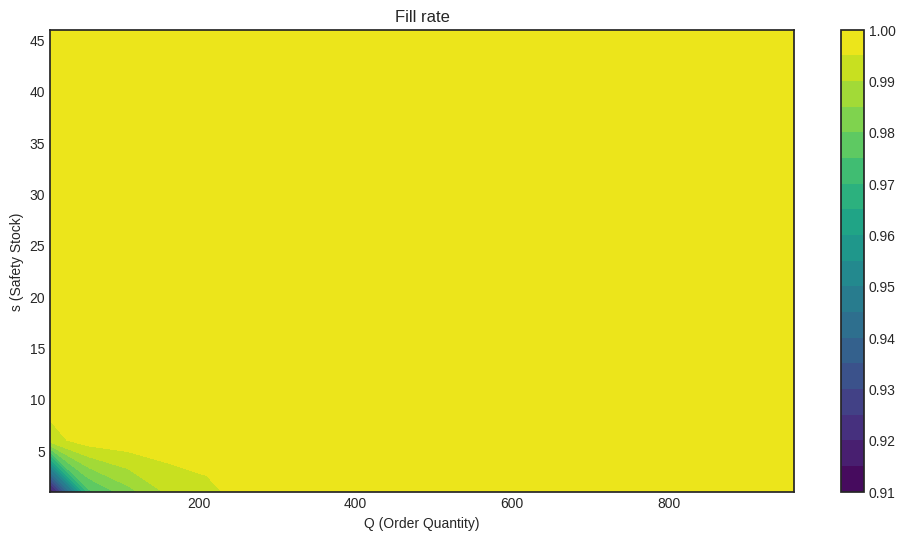

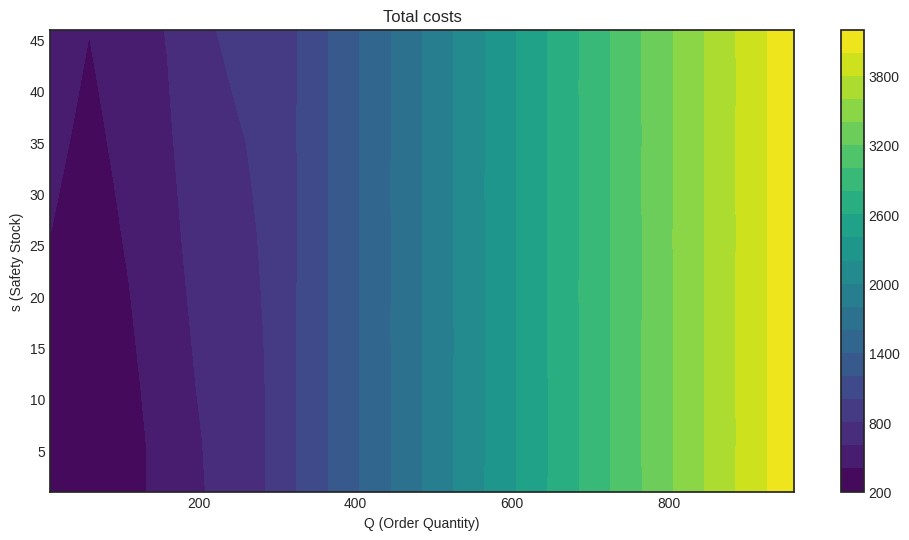

In [17]:
# Function to visualize contour plots
def plot_contours(Q_range, s_range, metric_matrix, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(12, 6))
    c = ax.contourf(Q_range, s_range, metric_matrix.T, cmap='viridis', levels=20)
    fig.colorbar(c, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

# Parameters
n_simulations = 100
n_sim_steps = 50
penalty_rate = 5  # Penalty cost per unit of unmet demand

# Run simulations
evaluation_results, holding_costs, fixed_costs, stockout_costs, total_costs, fill_rates, service_levels = evaluate_scenarios(n_simulations, n_sim_steps, Q_range, s_range, config, penalty_rate)

# Prepare matrices for contour plots
fill_rate_matrix = np.array([res['avg_fill_rate'] for res in evaluation_results]).reshape(len(Q_range), len(s_range))
total_cost_matrix = np.array([res['avg_total_cost'] for res in evaluation_results]).reshape(len(Q_range), len(s_range))

# Plot contour visualizations
plot_contours(Q_range, s_range, fill_rate_matrix, "Fill rate", "Q (Order Quantity)", "s (Safety Stock)")
plot_contours(Q_range, s_range, total_cost_matrix, "Total costs", "Q (Order Quantity)", "s (Safety Stock)")
